In this post we will analyze the dataset on students’ performance and develop classification models that will predict the likelihood that a given student will pass and choose the the most effective model that uses the least amount of computation costs. The three models that explored here are logistic regression, naive bayes and random forests. I will start first with brief technical summary of the models (some machine learning background is assumed).

##  Exploring the Data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  

In [16]:
# Read student data
student_data = pd.read_csv("student-data.csv")
# Note: The last column 'passed' is the target/label, all other are feature columns

In [4]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = len(student_data)
n_features = student_data.shape[1] -1
n_passed = sum(student_data['passed']=='yes')
n_failed = sum(student_data['passed']=='no')
grad_rate = (n_passed/float(n_students)) *100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [5]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [7]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=0)


Training set: 300 samples
Test set: 95 samples


## Training and Evaluating Models

### Logistic Regression

Since the target values can have only two classes, passed and failed, where pass is the positive class and failed is the negative one and the features include both binarized categorical values and numeric values, the logistic regression model would be a suitable one here. 

The logistic regression is parametric, discriminative classification model and one of the most widely applied machine learning due to its low computational complexity of fitting the model parameters and high interpretability of the model [1]. Since it is a classification model, it is used widely in many fields including image recognition, social science and medicine. 


Let's say we have an observation with $p$ features each, $X=(x_{1}, x_{2},...,x_{p})$, and the vector $Y=(y_{1}, y_{2}, ...,y_{c})$ which states the binary class membership of the observed vector of predictors (in our case we only have $c=2$ classes). The logistic regression model calculates the class membership probability  for one of the two categories in the data set by the sigmoid function:
 
$$p(y=1| X,W)=\frac { 1 }{ 1+{ exp }^{ -\left( { { w }_{ 0 }+\sum _{ i=1 }^{ p }{ { w }_{ i }{ x }_{ i } }  } \right)  } } $$


$$p(y=0|X,W)=\frac { { exp }^{ -\left( { { w }_{ 0 }+\sum _{ i=1 }^{ p }{ { w }_{ i }{ x }_{ i } }  } \right)  } }{ 1+{ exp }^{ -\left( { { w }_{ 0 }+\sum _{ i=1 }^{ p }{ { w }_{ i }{ x }_{ i } }  } \right)  } } $$

where $W=(x_{0}, x_{1},x_{2},...,x_{p})$ are the regression coefficients. The coefficients are estimated (or trained) by either maximizing the maximum likelihood estimation or minimizing the error function. Assuming we are going with the second option, the error function is:

$$
E(w)=\frac { 1 }{ n } \sum _{ i=1 }^{ n } \left[ -{ y }^{ (i) }log\left( \frac { 1 }{ 1+{ exp }^{ -\left( { { w }_{ 0 }+\sum _{ i=1 }^{ p }{ { w }_{ i }{ x }_{ i } }  } \right)  } }  \right) -(1-{ y }^{ (i) })log\left( \frac { { exp }^{ -\left( { { w }_{ 0 }+\sum _{ i=1 }^{ p }{ { w }_{ i }{ x }_{ i } }  } \right)  } }{ 1+{ exp }^{ -\left( { { w }_{ 0 }+\sum _{ i=1 }^{ p }{ { w }_{ i }{ x }_{ i } }  } \right)  } }  \right)  \right]$$

where $n$ is the total number of observation. One of the disadvattiges of logistic regreesion is that it's prone to overfitting. To avoide this, we can add either L1 or L2 regulaization to the error function. The time complexity for this optimization problem with the number of observations, $O(n)$ and the space complexity $O(nm)$ where m is the number of features.

### Gaussian Naive Bayes

Because we are also looking for a model that uses the least amount of computation costs, the next model we will explore is the Guassian  Niave Bayes. It is one of the most computationally efficient and effective learning algirthims [3]. Moreover, since administrators might want to predict the graduation rate of small groups of students, the model is also effective when the training size is small. 

Here, unlike logistic regression where the model tries to learn $p(y|x)$ directly, naive bayes model try to model $p(x|y)$ and $p(y)$ based on the assumption that the features are conditionally independent of each other. It is mostly used in text classification, medical diagnosis and spam filtering.  

Using the same notation as above where the feature vector $X=(x_{1}, x_{2},...,x_{n})$ and the class vector $Y=(y_{1}, y_{2}, ...,y_{c})$, according to bayes rule the probability of getting the class $y_{k}$ given the feature vector $X$ is:

$$p(y_{ k }|X)=\frac { p(X|{ y }_{ k })p({ y }_{ k }) }{ p(X) }$$ 

Since the naive bayes assumes that the features are indepedent:

$$p(X|y)=\prod _{ i=1 }^{ n }{ p({ x }_{ i }|{ y }_{ k }) }$$

There fore the equation simplifies to:

$$p({ y }_{ k }|X)=\frac { p({ y }_{ k })\prod _{ i=1 }^{ n }{ p({ x }_{ i }|{ y }_{ k }) }  }{ \sum _{ j=1 }^{ c }{ p({ y }_{ j })\prod _{ i=1 }^{ n }{ p({ x }_{ i }|{ y }_{ j }) }  }  } $$

And then we calculate the probabilty of all the classis and the one with the highest probability is the predicted class given a set of features. This is known as the maximum a posteriori or MAP decision rule The simplified rule as:

$$y={ \underset { { y }_{ k } }{ argmax }  }\ p({ y }_{ k })\prod _{ i=1 }^{ n }{ p({ x }_{ i }|{ y }_{ k }) } $$

In the case of Gaussain Niave bayes, The likelihood of the features is assumed to be Gaussian:



$$p({ x }_{ i }|y)=\frac { 1 }{ \sqrt { 2\pi { \sigma  }_{ { x }_{ i },y }^{ 2 } }  } { exp }{ \left( -\frac { { ({ x }_{ i }-{ \mu  }_{{ x }_{ i }, y }) }^{ 2 } }{ 2{ \sigma  }_{ { x }_{ i },y }^{ 2 } }  \right)  }$$

for a more comrehensive explaiantion of the model, check out [this chapter](https://www.cs.cmu.edu/~tom/mlbook/NBayesLogReg.pdf) from Tom Micheal's Machine learning book. 


One of the advantages of naive bayes is that, as mentioned above, it only requires a small amount of training data to estimate the parameters necessary for classification. It also fast to train and to classify with a time complexity of $O(np)$ where $n$ is the number of training examples and p is the number of features and space complexity of $O(pq)$ where q is values for each feature. Moreover, it can handle missing data pretty well. However, one main disadvantage of naive bayes is that it has strong feature independence assumptions and therefore can be fooled by correlated features. It also does not perform well on large data. 

### Random Forests

The current data only has the data of 395 students without any missing values. In the real world however, the data will be in hundred of thousands or even millions with many missing values. Therefore, we're going to choose a model that can handle large datasets as well as missing values. This model is random forests. 

Random Forests model can be used for both regression and classification problems in wide range of applications ranging from biology(recognizing the important elements in protein sequences) to image recognition. One interesting application is predicting body movement in Microsoft's Kinect. 

The model is an  aggregation (ensemble) of another weaker machine learning model, decision trees. One of the main issues with decision trees is that it is can easilty overfit the data. Random forests overcome this problem by using multiple decision trees and choosing the classification having the most votes from those trees. The procedure is as follows:
1. A bootstrapped sample is taken from the training set.
2. A random number of features are chosen to form a decision tree. 
3. Each tree is trained and grown to the fullest extent possible without pruning. 

The steps above are repeated multiple times to random decision trees. Each tree gives a classification and the classification that has the most votes is chosen. The diagram below illustrate the process where we have n decision trees. 

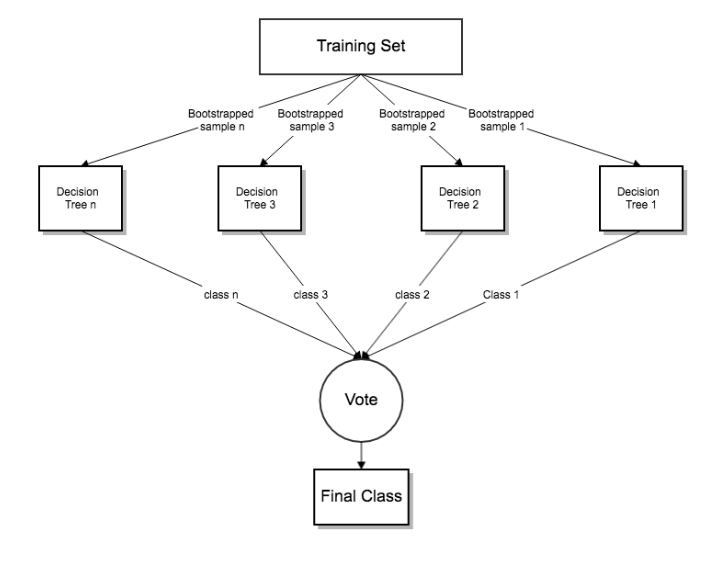

In [11]:
#nbviewer cant view loca files so I used matplolib to view the figure
plt.figure(figsize=(12, 12))
plt.axis('off')
img=mpimg.imread('diagram.png')
imgplot = plt.imshow(img)

Random forests is one most popular and best performing machine learning algorithms [2]. The reason for their popularity is its excellent prediction performance, as well as its invariance to its feature units. Moreover, unlike logistic regression and naive bias, it can handle categorial data very well. However, one disadvantage is the it uses large memory when training. Its space complexity increases exponentially with a base of 2. It also take longer to train than the previous models where the time complexity is $O(n(dm\log m))$. $n$,$d$ and $m$ are the number of trees, the number of features and the number of instances, respectively. Moreover, random forests are difficult to interpret. 




In [8]:
# Train a model
import time
from sklearn.metrics import f1_score


def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    training_time = end-start
    return training_time

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    predicting_time = end-start
    f1 = f1_score(target.values, y_pred, pos_label='yes')
    return f1 , predicting_time

def f1_scores_times(clf):
    scores_training = []
    scores_testing = []
    training_times = []
    predicting_times = []
    for i in [100,200,300]:
        training_times.append(train_classifier(clf, X_train[:i], y_train[:i]))
        predicting_times.append(predict_labels(clf, X_train[:i], y_train[:i])[1])
        scores_training.append(predict_labels(clf, X_train[:i], y_train[:i])[0])
        scores_testing.append(predict_labels(clf, X_test, y_test)[0])
        
    return scores_training, scores_testing, training_times, predicting_times

def table(clf, name):
    raw_data = {
        'F1 score for train set': f1_scores_times(clf)[0],
        'F1 score for test set':  f1_scores_times(clf)[1],
        'Training Time': f1_scores_times(clf)[2],
        'Predicting Time':  f1_scores_times(clf)[3]}
    table = pd.DataFrame(raw_data,index=[100, 200, 300],
                          columns = ['F1 score for train set', 
                                     'F1 score for test set',
                                     'Training Time', 
                                     'Predicting Time'])
    table.index.name = 'Training size'
    table.columns.name = name
    #table = table.style.set_caption(name)
    
    return table

In [10]:
table_logistic

Logistic Regression,F1 score for train set,F1 score for test set,Training Time,Predicting Time
Training size,,,,
100,0.832117,0.764706,0.001165,0.000180
200,0.832168,0.782609,0.001451,0.000142
300,0.836283,0.800000,0.002149,0.000152


In [11]:
table_NB

Gaussian Niave Bayes,F1 score for train set,F1 score for test set,Training Time,Predicting Time
Training size,,,,
100,0.854962,0.748092,0.000679,0.000478
200,0.832061,0.713178,0.000726,0.000376
300,0.808824,0.750000,0.000753,0.000358


In [12]:
table_RF

Random Forests,F1 score for train set,F1 score for test set,Training Time,Predicting Time
Training size,,,,
100,1,0.763889,0.043082,0.001606
200,1,0.751773,0.045503,0.001894
300,1,0.780142,0.059970,0.003104


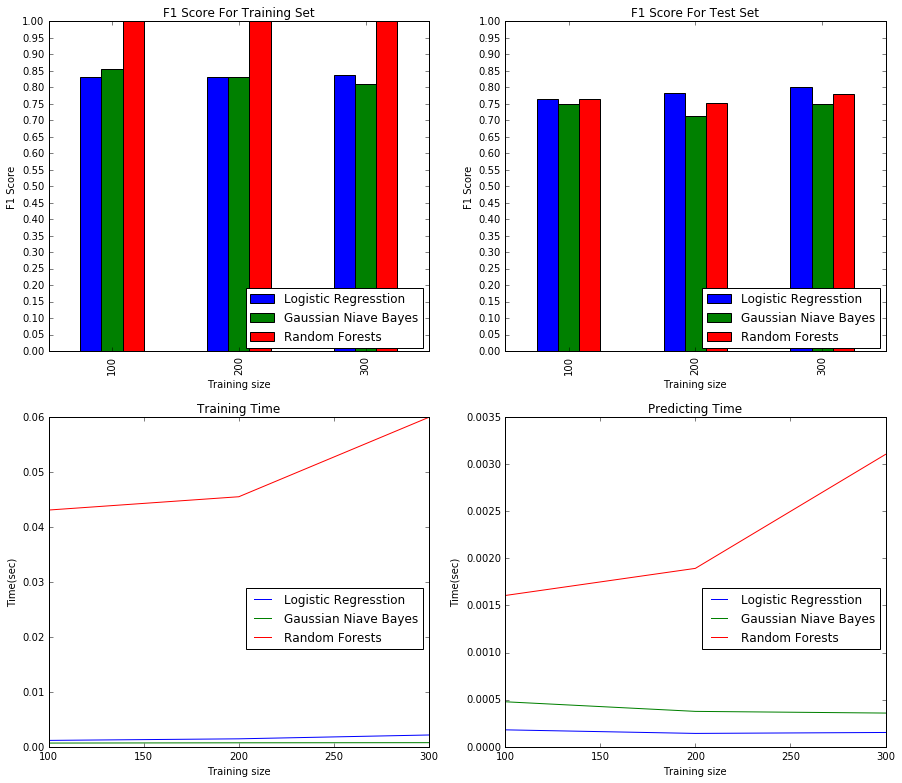

In [13]:
def plot():
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,13))    #plt.figure(figsize=(15, 7))
    raw_data1 = {
            'Logistic Regresstion': table_logistic['F1 score for train set'],
            'Gaussian Niave Bayes': table_NB['F1 score for train set'],
            'Random Forests': table_RF['F1 score for train set']}
    table1 = pd.DataFrame(raw_data1,index=[100, 200, 300],
                              columns = ['Logistic Regresstion', 'Gaussian Niave Bayes',
                                        'Random Forests'])
    table1.index.name = 'Training size'
    raw_data2 = {
            'Logistic Regresstion': table_logistic['F1 score for test set'],
            'Gaussian Niave Bayes': table_NB['F1 score for test set'],
            'Random Forests': table_RF['F1 score for test set']}
    table2 = pd.DataFrame(raw_data2,index=[100, 200, 300],
                              columns = ['Logistic Regresstion', 'Gaussian Niave Bayes',
                                        'Random Forests'])
    table2.index.name = 'Training size'
    raw_data3 = {
            'Logistic Regresstion': table_logistic['Training Time'],
            'Gaussian Niave Bayes': table_NB['Training Time'],
            'Random Forests': table_RF['Training Time']}
    table3 = pd.DataFrame(raw_data3,index=[100, 200, 300],
                              columns = ['Logistic Regresstion', 'Gaussian Niave Bayes',
                                        'Random Forests'])
    table3.index.name = 'Training size'
    raw_data4 = {
            'Logistic Regresstion': table_logistic['Predicting Time'],
            'Gaussian Niave Bayes': table_NB['Predicting Time'],
            'Random Forests': table_RF['Predicting Time']}
    table4 = pd.DataFrame(raw_data4,index=[100, 200, 300],
                              columns = ['Logistic Regresstion', 'Gaussian Niave Bayes',
                                        'Random Forests'])
    table4.index.name = 'Training size'
    
    table1.plot(kind='bar',ax=axes[0,0],yticks=np.arange(0, 1.05, 0.05)).legend(bbox_to_anchor=(1, .21))
    axes[0,0].set_title('F1 Score For Training Set'); axes[0,0].set_ylabel('F1 Score')
    table2.plot(kind='bar',ax=axes[0,1],yticks=np.arange(0, 1.05, 0.05)).legend(bbox_to_anchor=(1, .21))
    axes[0,1].set_title('F1 Score For Test Set'); axes[0,1].set_ylabel('F1 Score')
    table3.plot(kind='line',ax=axes[1,0]).legend(bbox_to_anchor=(1, .5))
    axes[1,0].set_title('Training Time'); axes[1,0].set_ylabel('Time(sec)')
    table4.plot(kind='line',ax=axes[1,1]).legend(bbox_to_anchor=(1, .5))
    axes[1,1].set_title('Predicting Time'); axes[1,1].set_ylabel('Time(sec)')

plot()                         

## Choosing the Best Model

From the statistics above, logistic regression has the highest predicting performance on the test set for all training sizes. It is also the most efficient when it comes to predicting time. However, naive bayes is the most efficient when it comes to training time but its prediction accuracy is the worst on the training set. Random forests performs pretty well in on the test set and its prediction accuracy is actually not far from logistic regression. However, it's the most computationally expensive in both training and predicting. Therefore, I would choose the logistic regression because of its excellent performance and time efficiency. 

In laymein terms, logistic regression makes predictions using a mathematical model that calculates the probability that a student passes or fails, where any probability below 0.5 means that the student failed and any probability above 0.5 means the student passed. This mathematical model is derived using the training data where the model is trained (or optimized) so that it gives the correct probabilities from the students's features. To make a prediction, the trained model takes a student features and calculates the probability that he/she passes. 

The model can be improved by fine-tuning and optimising its paramters settings. The paramters here are the regulization methods, l1 or l2, and the stregth of the regulaization, a range of values from 0.1 to 1. This process requires doing a `GridSearch` over the parameters and then get the ones that gives the highest f1 score. 

In [14]:
from sklearn import grid_search
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit

classifier = LogisticRegression()
c = np.arange(0.01,1.01,0.01)
parameters = {'C': c, 'penalty':['l1','l2']}
f1_scorer = make_scorer(f1_score, pos_label="yes")
sss = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.24, random_state=ran_state)

reg = grid_search.GridSearchCV(classifier, param_grid=parameters, scoring=f1_scorer, cv=sss)
reg.fit(X_train, y_train)
clf = reg.best_estimator_
clf.get_params()

{'C': 0.11,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [15]:
f1_score(y_test,reg.predict(X_test), pos_label='yes')

0.79166666666666663

### References

[1] E. Makalic and D. F. Schmidt. Review of Modern Logistic Regression Methods with Application to Small and Medium Sample Size Problems. Lecture Notes in Computer Science, 6464/2011:2013-222,2011.

[2] L. Breiman, “Random forests,” Machine Learning, vol. 4, no. 1, pp. 5–32, October 2001.

[3] Zhang, Harry, and Jiang Su. "Naive Bayesian Classifiers for Ranking." Machine Learning: ECML 2004 Lecture Notes in Computer Science (2004): 501-12. 

[4] Andrew Ng's CS 229 [course notes](http://cs229.stanford.edu/notes/cs229-notes1.pdf) on supervised learning.

[5] Makalic, Enes, and Daniel Francis Schmidt. "Review of Modern Logistic Regression Methods with Application to Small and Medium Sample Size Problems." AI 2010: Advances in Artificial Intelligence Lecture Notes in Computer Science (2010): 213-22.